# **Importing required libraries**

In [61]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout


In [62]:
# Loading dataset

data = pd.read_table("Sentiment140.tenPercent.sample.tweets.tsv")

In [63]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


# **Data Preprocessing**

In [64]:
# Check for null data
null_data = data.isnull().sum()
print("Null data:\n", null_data)

# Check for duplicates
duplicate_rows = data.duplicated().sum()
print("\nDuplicate rows:", duplicate_rows)

Null data:
 sentiment_label    0
tweet_text         0
dtype: int64

Duplicate rows: 553


In [65]:
# Remove duplicate data
data = data.drop_duplicates()

# Reset index
data.reset_index(drop=True, inplace=True)

In [66]:
# Check for duplicates
duplicate_rows = data.duplicated().sum()
print("\nDuplicate rows:", duplicate_rows)


Duplicate rows: 0


In [67]:
print(data.columns)

Index(['sentiment_label', 'tweet_text'], dtype='object')


In [68]:
def preprocess_text(sen):
  # Removing html tags
  sentence = remove_tags(sen)

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple space
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

In [69]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('', text)

In [70]:
X = []
sentences = list(data['tweet_text'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [71]:
X[4]

'very sad that http www fabchannel com has closed down One of the few web services that ve used for over years '

In [72]:
y = data['sentiment_label']

y = np.array(list(map(lambda x : 1 if x == 4 else 0,y)))

# **Exploratory Data Analysis (EDA)**

Positive    79797
Negative    79650
Name: sentiment_label, dtype: int64


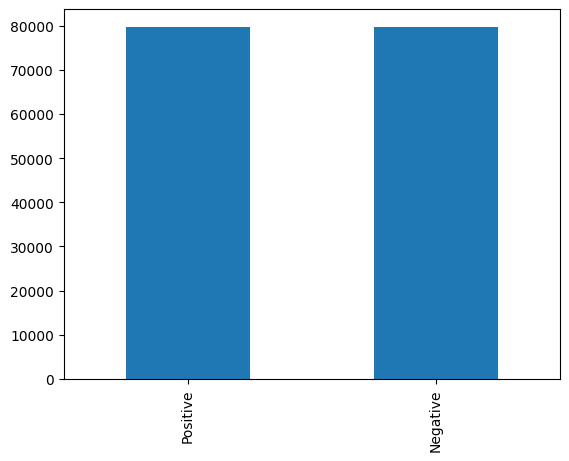

In [89]:
# Distribution of the sentiment label

sentiment ={0:"Negative",4:"Positive"}
print(data.sentiment_label.apply(lambda x:sentiment[x]).value_counts())
data.sentiment_label.apply(lambda x:sentiment[x]).value_counts().plot(kind ='bar')
plt.show()

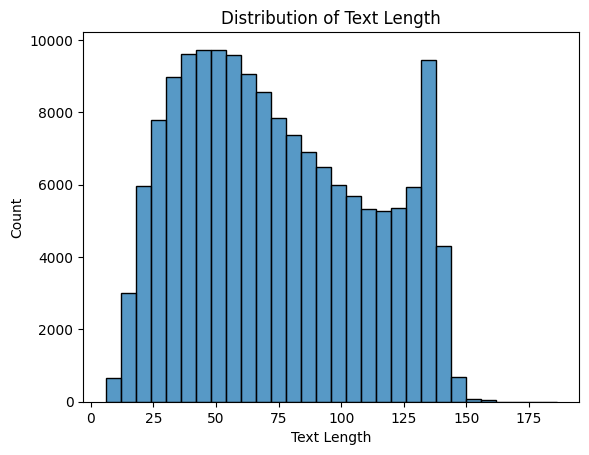

In [74]:
# Distribution of Text Length
data['text_length'] = data['tweet_text'].apply(len)
sns.histplot(data['text_length'], bins=30)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

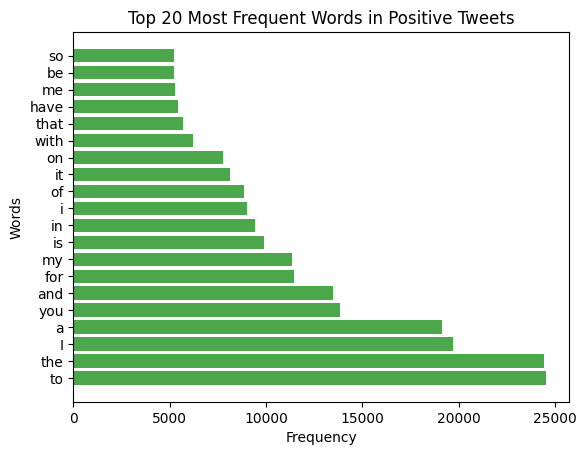

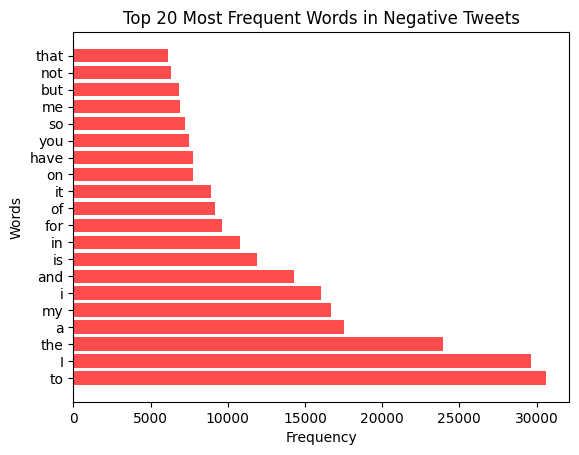

In [75]:
# Word Frequency Analysis
from collections import Counter

positive_texts = data[data['sentiment_label'] == 4]['tweet_text']
negative_texts = data[data['sentiment_label'] == 0]['tweet_text']

positive_word_freq = Counter(" ".join(positive_texts).split()).most_common(20)
negative_word_freq = Counter(" ".join(negative_texts).split()).most_common(20)

# Plotting word frequencies
plt.barh(range(len(positive_word_freq)), [freq[1] for freq in positive_word_freq], align='center', color='green', alpha=0.7)
plt.yticks(range(len(positive_word_freq)), [freq[0] for freq in positive_word_freq])
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in Positive Tweets')
plt.show()

plt.barh(range(len(negative_word_freq)), [freq[1] for freq in negative_word_freq], align='center', color='red', alpha=0.7)
plt.yticks(range(len(negative_word_freq)), [freq[0] for freq in negative_word_freq])
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in Negative Tweets')
plt.show()

# **Splitting dataset for training and test**

In [76]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Bidirectional
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve,roc_auc_score, auc, precision_recall_curve, confusion_matrix


In [78]:


# Convert numpy arrays to lists of strings
X_train_texts = [str(text) for text in X_train]
X_test_texts = [str(text) for text in X_test]

max_words = 5000  # Maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

vocab_size = len(tokenizer.word_index) + 1

max_len = 100  # Maximum length of sequences
X_train = pad_sequences(X_train_seq, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test_seq, padding='post', maxlen=max_len)

In [96]:
# Simple Neural Network

maxlen = 100
nn_model = Sequential()
#embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
nn_model.add(Embedding(input_dim=vocab_size, output_dim=10, input_length=maxlen))
#model.add(embedding_layer)

# Add more layers
nn_model.add(Flatten())
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.5))  # Optional dropout layer to reduce overfitting
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(0.3))  # Optional dropout layer to reduce overfitting
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.2))  # Optional dropout layer to reduce overfitting
nn_model.add(Dense(1, activation='sigmoid'))

In [97]:
nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
print(nn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 10)           50000     
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               256256    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)               

In [98]:
history = nn_model.fit(X_train, y_train, batch_size = 32, epochs = 5, verbose = 1, validation_split = 0.2)

Epoch 1/5
3189/3189 [==============================] - 50s 15ms/step - loss: 0.5230 - acc: 0.7412 - val_loss: 0.4641 - val_acc: 0.7829
Epoch 2/5
3189/3189 [==============================] - 37s 12ms/step - loss: 0.4529 - acc: 0.7937 - val_loss: 0.4621 - val_acc: 0.7848
Epoch 3/5
3189/3189 [==============================] - 32s 10ms/step - loss: 0.4229 - acc: 0.8076 - val_loss: 0.4681 - val_acc: 0.7796
Epoch 4/5
3189/3189 [==============================] - 34s 11ms/step - loss: 0.3913 - acc: 0.8231 - val_loss: 0.4794 - val_acc: 0.7772
Epoch 5/5
3189/3189 [==============================] - 34s 11ms/step - loss: 0.3617 - acc: 0.8374 - val_loss: 0.5143 - val_acc: 0.7728


In [99]:
score = nn_model.evaluate(X_test, y_test, verbose = 1)

print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

997/997 [==============================] - 4s 4ms/step - loss: 0.5246 - acc: 0.7639
Test Score:  0.5246338248252869
Test Accuracy:  0.7638758420944214


997/997 [==============================] - 4s 4ms/step


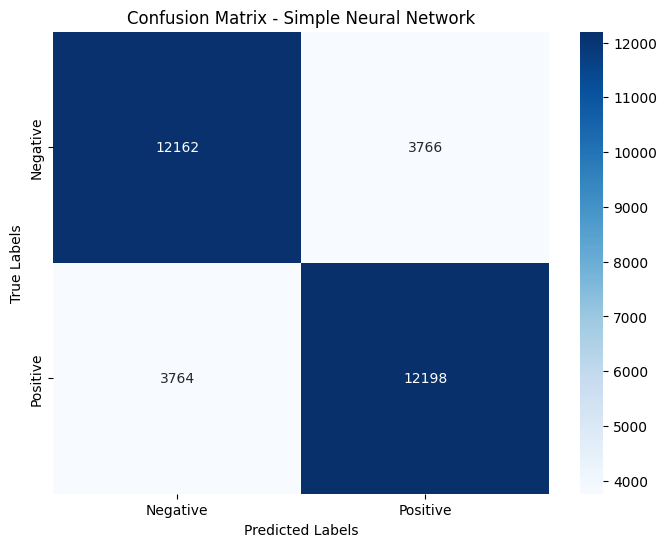

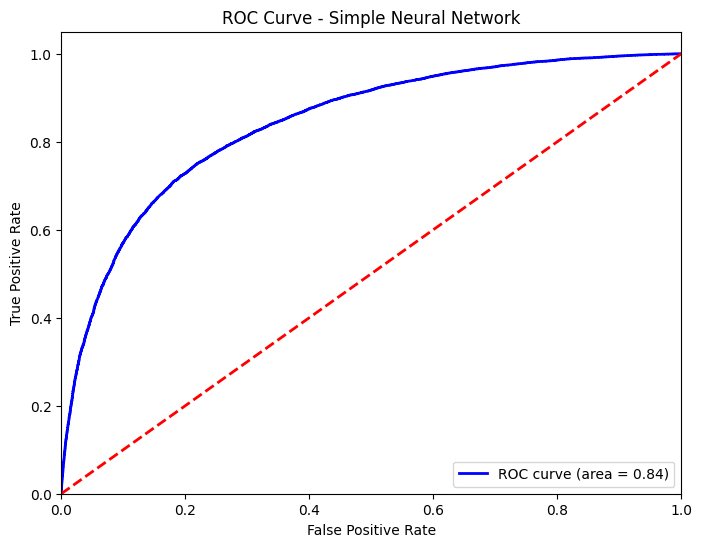

In [128]:
# Make predictions
y_pred_snn = nn_model.predict(X_test_padded)

# Round predictions to 0 or 1
y_pred_snn_binary = (y_pred_snn > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_snn_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Simple Neural Network')
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_snn)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Simple Neural Network')
plt.legend(loc="lower right")
plt.show()

In [83]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=100, input_length=maxlen))  # Embedding layer
cnn_model.add(Conv1D(128, 5, activation='relu'))  # Convolutional layer
cnn_model.add(GlobalMaxPooling1D())  # Global max pooling layer
cnn_model.add(Dense(1, activation='sigmoid'))  # Dense output layer

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          500000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 564257 (2.15 MB)
Trainable params: 564257 (2.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [85]:
# CNN Model history
history = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 5, verbose = 1, validation_split = 0.2)
score = cnn_model.evaluate(X_test, y_test, verbose = 1)

# Printing test accuracy
print("Test Score CNN Model: ", score[0])
print("Test Accuracy CNN Model: ", score[1])

Epoch 1/5
3189/3189 [==============================] - 139s 44ms/step - loss: 0.0984 - accuracy: 0.9650 - val_loss: 0.9027 - val_accuracy: 0.7532
Epoch 2/5
3189/3189 [==============================] - 134s 42ms/step - loss: 0.0692 - accuracy: 0.9755 - val_loss: 1.0304 - val_accuracy: 0.7535
Epoch 3/5
3189/3189 [==============================] - 135s 42ms/step - loss: 0.0543 - accuracy: 0.9809 - val_loss: 1.1256 - val_accuracy: 0.7493
Epoch 4/5
3189/3189 [==============================] - 131s 41ms/step - loss: 0.0443 - accuracy: 0.9839 - val_loss: 1.2675 - val_accuracy: 0.7513
Epoch 5/5
997/997 [==============================] - 11s 11ms/step - loss: 1.4045 - accuracy: 0.7362
Test Score CNN Model:  1.404477834701538
Test Accuracy CNN Model:  0.736218273639679


997/997 [==============================] - 21s 21ms/step


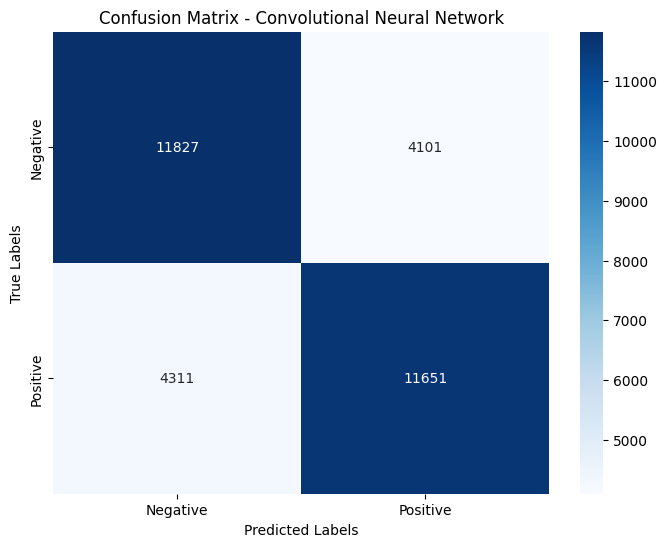

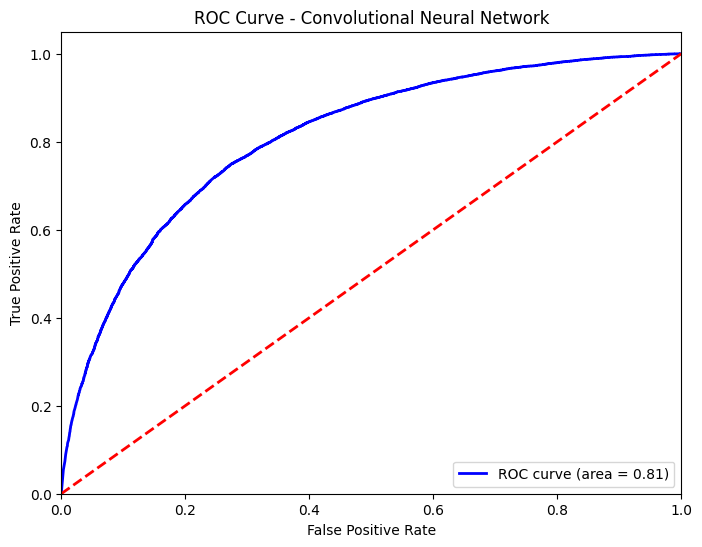

In [132]:
# Make predictions
y_pred_cnn = cnn_model.predict(X_test_padded)

# Round predictions to 0 or 1
y_pred_cnn_binary = (y_pred_snn > 0.5).astype(int)

# Calculate confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_snn_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Convolutional Neural Network')
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_cnn)

# Calculate AUC score
roc_auc_cnn = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Convolutional Neural Network')
plt.legend(loc="lower right")
plt.show()

In [86]:
# Define max_len and vocab_size
max_len = 100
vocab_size = 5000

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Fit the model to the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                      

997/997 [==============================] - 4s 4ms/step


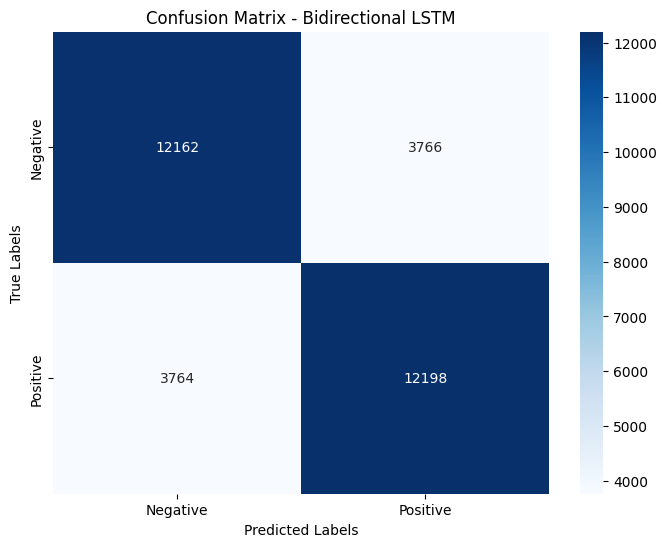

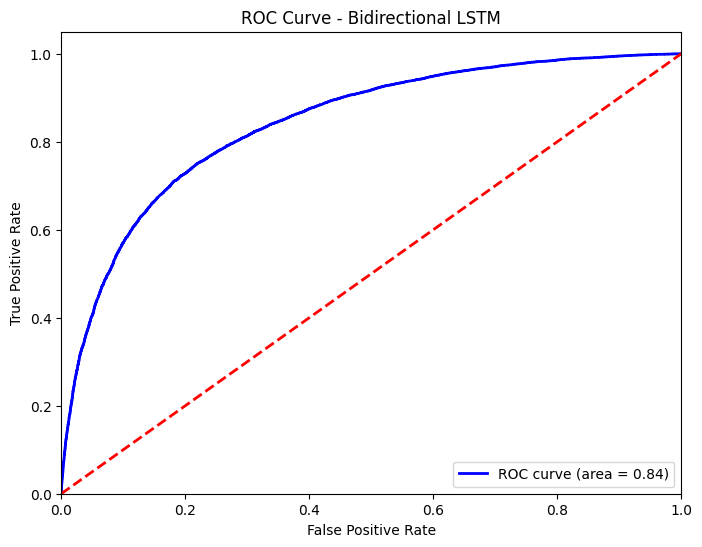

In [131]:
# Make predictions
y_pred_lstm = model.predict(X_test_padded)

# Round predictions to 0 or 1
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)

# Calculate confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm)

# Calculate AUC score
roc_auc_lstm = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bidirectional LSTM')
plt.legend(loc="lower right")
plt.show()

In [101]:
# Random Forest Classifier

# Convert numpy array to list of strings
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# Build Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Random Forest Classifier
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
rf_model.fit(X_train_tfidf, y_train)

# Predictions using Random Forest Classifier
rf_preds = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_preds)
print("\nRandom Forest Accuracy:", rf_acc)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))


Random Forest Accuracy: 0.7618689244277203
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     15928
           1       0.78      0.73      0.76     15962

    accuracy                           0.76     31890
   macro avg       0.76      0.76      0.76     31890
weighted avg       0.76      0.76      0.76     31890

Random Forest Confusion Matrix:
[[12587  3341]
 [ 4253 11709]]


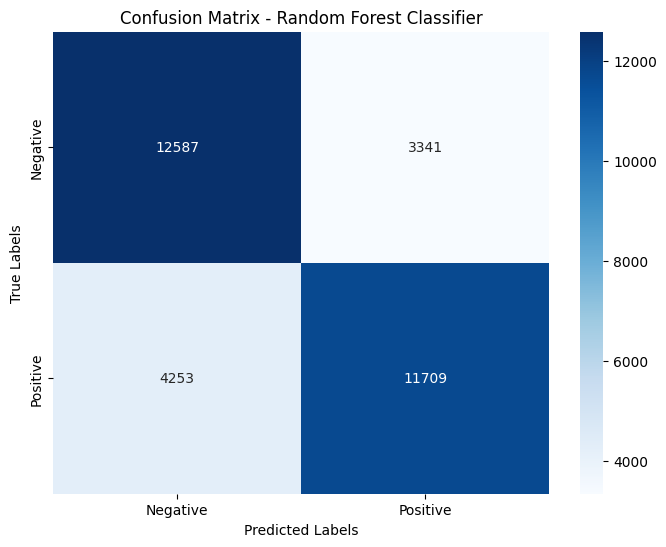

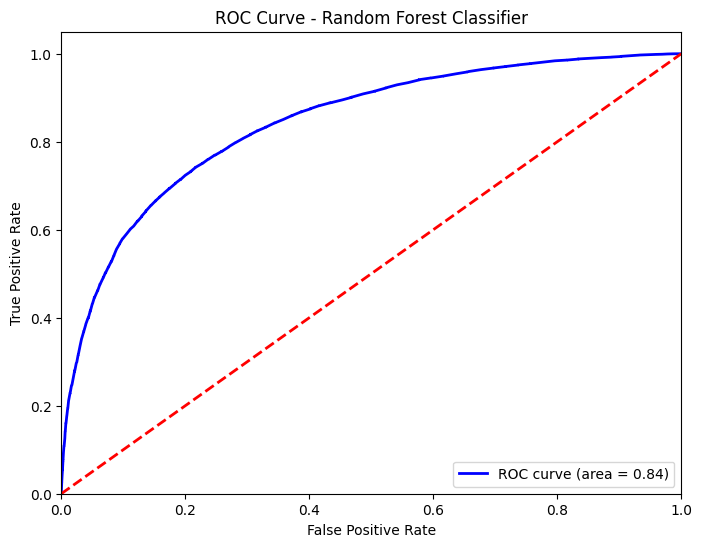

In [134]:
# Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Calculate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

# Calculate probabilities for ROC curve
y_pred_rf_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf_proba)

# Calculate AUC score
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [92]:
# Logistic Regression Model

from sklearn.feature_extraction.text import TfidfVectorizer

X_train = [str(item) for item in X_train]
X_test = [str(item) for item in X_test]

# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

# Initialize and train the Logistic Regression model with best hyperparameters
lr_model = grid_search.best_estimator_
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_preds = lr_model.predict(X_test_tfidf)

# Evaluate
lr_accuracy = accuracy_score(y_test, lr_preds)
print("Logistic Regression Accuracy:", lr_accuracy)
print(classification_report(y_test, lr_preds))

Logistic Regression Accuracy: 0.7765130134838507
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     15928
           1       0.77      0.78      0.78     15962

    accuracy                           0.78     31890
   macro avg       0.78      0.78      0.78     31890
weighted avg       0.78      0.78      0.78     31890



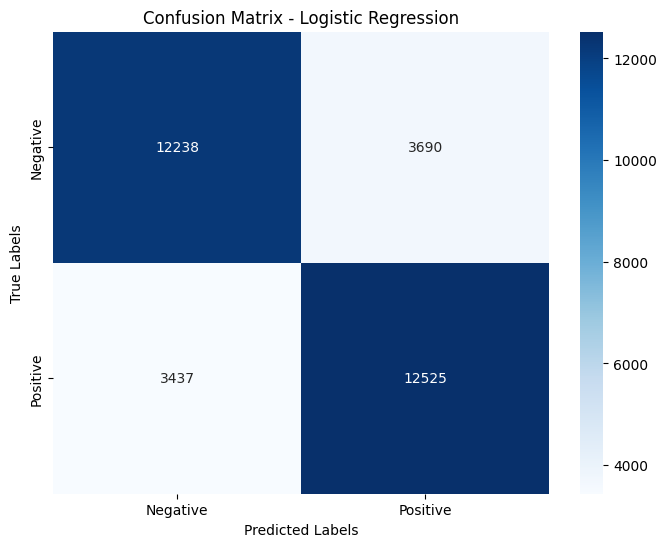

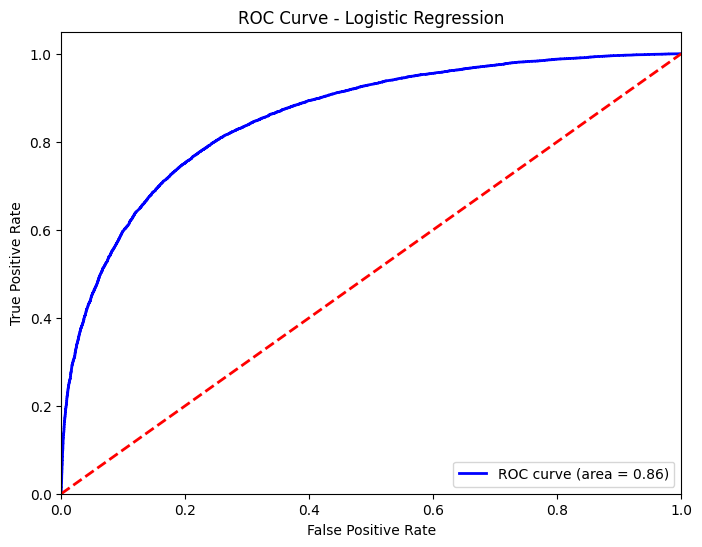

In [135]:
# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Calculate probabilities for ROC curve
y_pred_lr_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_lr_proba)

# Calculate AUC score
roc_auc_lr = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

997/997 [==============================] - 6s 6ms/step


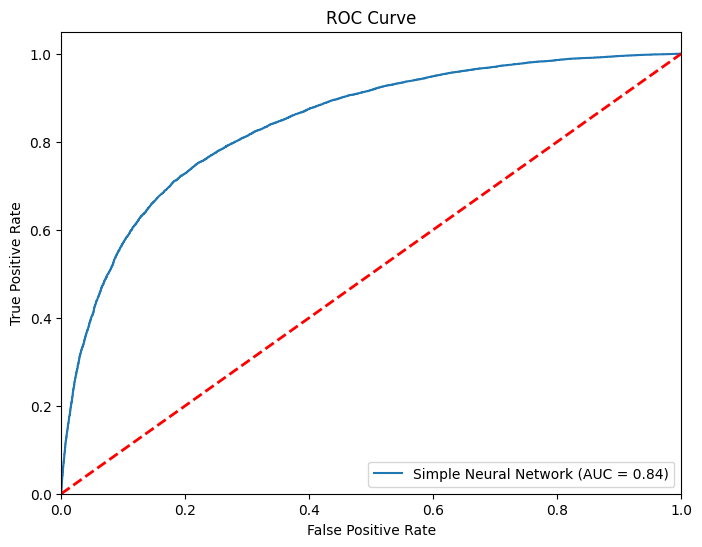

997/997 [==============================] - 11s 11ms/step


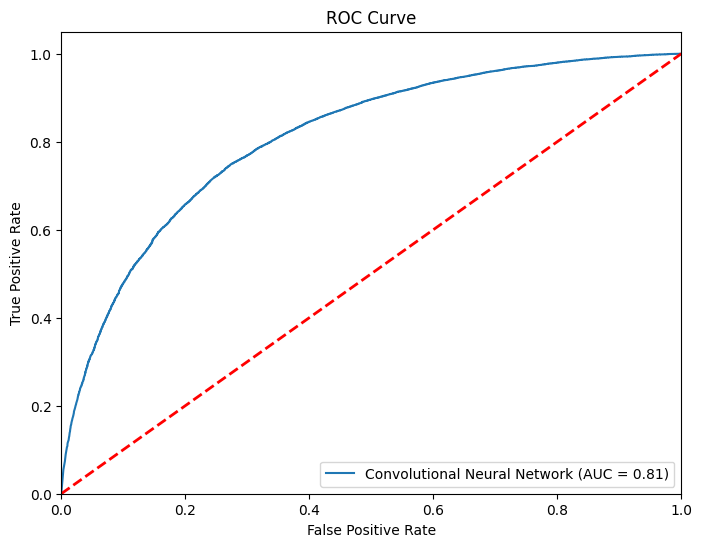

997/997 [==============================] - 3s 3ms/step


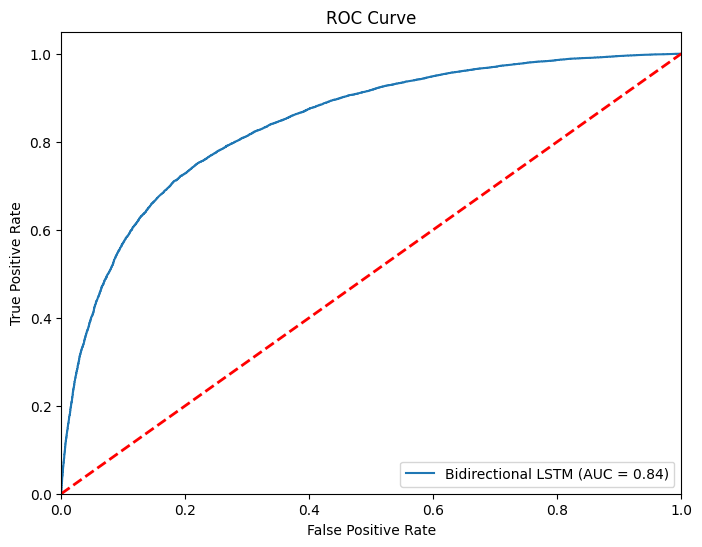

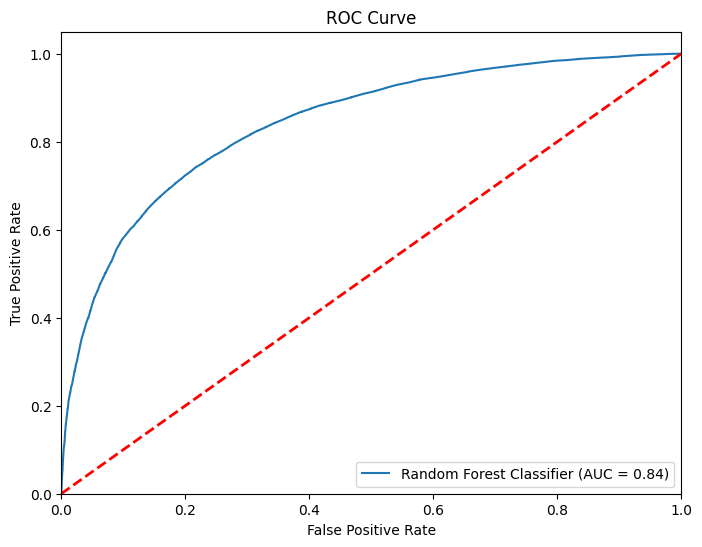

Accuracy Comparison:
Simple Neural Network: 0.7639
Convolutional Neural Network: 0.7362
Bidirectional LSTM: 0.7639
Random Forest Classifier: 0.7619

ROC AUC Comparison:
Simple Neural Network: 0.8416
Convolutional Neural Network: 0.8093
Bidirectional LSTM: 0.8416
Random Forest Classifier: 0.8417


In [136]:
# Define functions to calculate and plot ROC curves
def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

# Evaluate Simple Neural Network (SNN)
# Make predictions
y_pred_snn = nn_model.predict(X_test_padded)
# Round predictions to 0 or 1
y_pred_snn_binary = (y_pred_snn > 0.5).astype(int)
# Calculate accuracy
accuracy_snn = accuracy_score(y_test, y_pred_snn_binary)
# Calculate ROC AUC
fpr_snn, tpr_snn, _ = roc_curve(y_test, y_pred_snn)
roc_auc_snn = auc(fpr_snn, tpr_snn)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_snn, tpr_snn, roc_auc_snn, "Simple Neural Network")
plt.show()

# Evaluate Convolutional Neural Network (CNN) - Assuming cnn_model exists
# Make predictions
y_pred_cnn = cnn_model.predict(X_test_padded)
# Round predictions to 0 or 1
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)
# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn_binary)
# Calculate ROC AUC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_cnn, tpr_cnn, roc_auc_cnn, "Convolutional Neural Network")
plt.show()

# Evaluate Bidirectional LSTM - Assuming model exists
# Make predictions
y_pred_lstm = model.predict(X_test_padded)
# Round predictions to 0 or 1
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)
# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_lstm_binary)
# Calculate ROC AUC
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lstm, tpr_lstm, roc_auc_lstm, "Bidirectional LSTM")
plt.show()

# Evaluate Random Forest Classifier - Assuming rf_model exists
# Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# Calculate ROC AUC
y_pred_rf_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, "Random Forest Classifier")
plt.show()

# Compare accuracies
print("Accuracy Comparison:")
print(f"Simple Neural Network: {accuracy_snn:.4f}")
print(f"Convolutional Neural Network: {accuracy_cnn:.4f}")
print(f"Bidirectional LSTM: {accuracy_lstm:.4f}")
print(f"Random Forest Classifier: {accuracy_rf:.4f}")

# Compare ROC AUC scores
print("\nROC AUC Comparison:")
print(f"Simple Neural Network: {roc_auc_snn:.4f}")
print(f"Convolutional Neural Network: {roc_auc_cnn:.4f}")
print(f"Bidirectional LSTM: {roc_auc_lstm:.4f}")
print(f"Random Forest Classifier: {roc_auc_rf:.4f}")